# Quick Overview

In this task, you will implement a simple variant of [EfficientDet](https://arxiv.org/abs/1911.09070) for the segmentation task on [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 
It is a simplified task where the pet can be classified as foreground.

The dataset consists of RGB images of pets accompanied by a segmentation mask. The mask is an array of integers, that has entries equal to:
* 1 - for the pixels of the image that belong to the pet
* 2 - for the background
* 3 - for the ambiguous parts (like pet boundary and accessories) - we will call this an outline of a pet

The task is divided into four parts that contribute to your total score as follows:
* dataset preparation - 0.5p
* data visualization - 0.5p
* architecture implementation - 5p
* evaluation metrics - 1p
* training loop - 1p
* experiments - 2p

The first two subtasks consider dataset preparation (applying appropriate transforms) and data visualization.

In the next one, you are tasked with finishing the implementation of a model that should utilize:
* [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) backbone
* [BiFPN](https://arxiv.org/abs/1911.09070)-like module 
* Fully convolutional head for predicting whether a pixel belongs to the pet, the background, or the pet outline

Given a batch of input images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` the model should produce a tensor of shape `(BATCH, 3, PREDICTION_HEIGHT, PREDICTION_WIDTH)` consisting of logits used later for determining whether the point belongs to the pet, the background, or the pet outline.

Next, you will implement IOU and accuracy metrics, and finish the training loop (the evaluation function is already provided).

In the end, you will check how much the model benefits from the use of the feature pyramid and check the effects of the train set augmentation in a low data regime.

# Intro

## Libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Dataset Preparation (0.5p)

Read this section and provide input and target transforms. 
Transforms should pass the checks presented at the end of the section.

Input (Image) transforms should consist of:
* resize to ``(IMAGE_HEIGHT, IMAGE_WIDTH)``
* normalization with parameters matching ImageNet (provided below)

Target (Mask) transforms should consist of:
* resize to ``(PREDICTION_HEIGHT, PREDICTION_WIDTH)`` that maintains the domain (i.e. if each element of the mask was from the set {1, 2, 3} then so does each element after the resize)
* subtraction of 1 from each element of the target (to make 0 correspond to the pet, 1 to the background, and 2 to the outline)
* conversion to `torch.long`

Both inputs and targets should be converted to tensors.

Each image should have shape `(3, IMAGE_HEIGHT, IMAGE_WIDTH)`, 
whereas each target `(PREDICTION_HEIGHT, PREDICTION_WIDTH)`.

HINT:
* `torchvision.transforms.ToTensor()`
* `torchvision.transforms.PILToTensor()`
* `torchvision.transforms.Normalize(...)`
* `torchvision.transforms.Resize(..., interpolation=...)`
* `torchvision.transforms.Lambda(...)`

In [ ]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

def show_func(x):
  print(x.shape if hasattr(x, 'shape') else x.size)
  return x


input_transforms = torchvision.transforms.Compose(
    [    
        ## TODO {
          
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=image_net_mean,
                                         std=image_net_std),
     
        ## }
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        ## TODO {
        torchvision.transforms.Resize((PREDICTION_HEIGHT, PREDICTION_WIDTH),
                                      interpolation=torchvision.transforms.InterpolationMode.NEAREST),
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.Lambda(lambda x: x-1),
        torchvision.transforms.Lambda(lambda x: torch.squeeze(x, dim=0)),
        torchvision.transforms.Lambda(lambda x: x.type(torch.long)),
        ## }
    ]
)

In [ ]:
# Directory for dataset storage
DATA_PATH = "~/torch_datasets/oxford"

TRAIN_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="trainval",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)
TEST_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="test",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /root/torch_datasets/oxford/oxford-iiit-pet/images.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /root/torch_datasets/oxford/oxford-iiit-pet/annotations.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


In [ ]:
BATCH_SIZE = 16
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Let's ensure that shapes and types match our expectations.

In [ ]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long
assert (masks <= 2).all()
assert (masks >= 0).all()

## Data Visualization (0.5p)
Finish the implementation of `visualize_data` according to its docstring.

In [ ]:
def get_pet_mask(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet.
    """
    return (mask == 0).type(torch.long)


def get_pet_background(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the background.
    """
    return (mask == 1).type(torch.long)


def get_pet_outline(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet outline.
    """
    return (mask == 2).type(torch.long)

In [ ]:
def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    Draws a grid of images of size BATCH x 4.
    I'th row consists of the image, pet mask, pet outline, and background mask.
    """
    assert len(images.shape) == 4
    assert len(masks.shape) == 3
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    ## TODO {
        
    fig, axs = plt.subplots(num_images, 4, figsize=(15, 15))
    for index, (img, mask) in enumerate(zip(images, masks)):
      mask_pet = get_pet_mask(mask)
      mask_background = get_pet_background(mask)
      mask_outline = get_pet_outline(mask)

      unnormalized_img = img * torch.tensor(image_net_std).reshape(3,1,1) + torch.tensor(image_net_mean).reshape(3,1,1)
      axs[index, 0].imshow(unnormalized_img.permute((1,2,0)))
      axs[index, 0].set(xlabel='Original image')

      axs[index, 1].imshow(mask_pet)
      axs[index, 1].set(xlabel='Pet mask')

      axs[index, 2].imshow(mask_background)
      axs[index, 2].set(xlabel='Background mask')

      axs[index, 3].imshow(mask_outline)
      axs[index, 3].set(xlabel='Outline mask')

    for ax in axs.flat:
        ax.label_outer()

    ## }

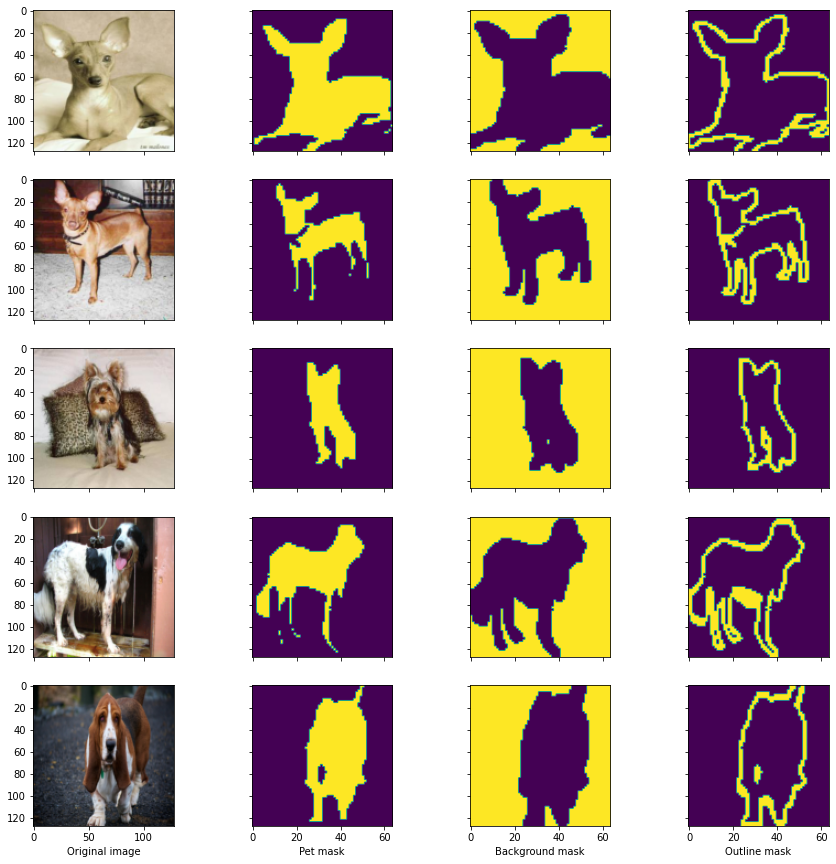

In [ ]:
visualize_data(images[:5], masks[:5])

# Model

## Backbone Selection

We are going to use [EfficientNet](https://arxiv.org/abs/1905.11946v5) as the backbone of our model. Below we install a PyTorch implementation and a package for model summarization.

In [ ]:
!pip install efficientnet_pytorch
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=719a55be456782fd83cd77a64a335c995dc3a55ff9bab879be9a4725f2838eb1
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from efficientnet_pytorch import EfficientNet
backbone = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
import torchinfo
torchinfo.summary(backbone, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH), device="cpu")

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 1000]                 --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 64, 64]           864
│    └─ZeroPad2d: 2-1                              [1, 3, 129, 129]          --
├─BatchNorm2d: 1-2                                 [1, 32, 64, 64]           64
├─MemoryEfficientSwish: 1-3                        [1, 32, 64, 64]           --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 64, 64]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 64, 64]           64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

The backbone has a method that allows easy feature extraction.
Below we inspect this method.

In [ ]:
import json

dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
features = backbone.extract_endpoints(dummy_input)

FEATURE_SHAPES = {
    feature_name: feature_data.shape for feature_name, feature_data in features.items()
}
FEATURE_CHANNELS = dict(
    list(
        {
            feature_name: feature_shape[1]
            for feature_name, feature_shape in FEATURE_SHAPES.items()
        }.items()
    )
)


print(json.dumps(FEATURE_SHAPES, indent=4))
print(json.dumps(FEATURE_CHANNELS, indent=4))

{
    "reduction_1": [
        1,
        16,
        64,
        64
    ],
    "reduction_2": [
        1,
        24,
        32,
        32
    ],
    "reduction_3": [
        1,
        40,
        16,
        16
    ],
    "reduction_4": [
        1,
        112,
        8,
        8
    ],
    "reduction_5": [
        1,
        320,
        4,
        4
    ],
    "reduction_6": [
        1,
        1280,
        4,
        4
    ]
}
{
    "reduction_1": 16,
    "reduction_2": 24,
    "reduction_3": 40,
    "reduction_4": 112,
    "reduction_5": 320,
    "reduction_6": 1280
}


## Architecture Implementation (5p)

### Backbone Utils (0.5p)
Finish the implementation of `BackBoneWrapper` according to docstrings.

In [ ]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class BackBoneWrapper(torch.nn.Module):
    """
    Given the input x of shape (BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    produces the list of features, each having out_channels channels.
    Features are taken from the output self.backbone.extract_endpoints(x)
    and converted using MatchChannels to have an appropriate number of channels.
    Features are ordered from the top to the bottom
    (first the ones of high resolution; note that FEATURE_CHANNELS maintains this order).
    """

    def __init__(self, out_channels):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained("efficientnet-b0")

        self.feature_channels = FEATURE_CHANNELS
        self.num_feature_levels = len(self.feature_channels.items())

        ## TODO{
        self.channel_matchers = torch.nn.ModuleDict(
            {feature_name: MatchChannels(in_channels=feature_channels, out_channels=out_channels)
            for feature_name, feature_channels in self.feature_channels.items()})
        ## }

    def forward(self, x):
        assert len(x.shape) == 4
        assert x.shape[1] == 3

        feature_level_dict = self.backbone.extract_endpoints(x)

        ## TODO{
        result = []
        for feaure_name in self.feature_channels:
          result.append(self.channel_matchers[feaure_name](feature_level_dict[feaure_name]))

        ## }

        assert len(result) == self.num_feature_levels
        for i in range(self.num_feature_levels):
            assert (
                result[i].shape[-2:]
                == feature_level_dict[f"reduction_{i+1}"].shape[-2:]
            )
        return result


dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
backbone = BackBoneWrapper(out_channels = 27)
y = backbone(dummy_input)
[x.shape for x in y]

Loaded pretrained weights for efficientnet-b0


[torch.Size([1, 27, 64, 64]),
 torch.Size([1, 27, 32, 32]),
 torch.Size([1, 27, 16, 16]),
 torch.Size([1, 27, 8, 8]),
 torch.Size([1, 27, 4, 4]),
 torch.Size([1, 27, 4, 4])]

### Feature Fusion (1.5p)
Finish the implementation of `FeatureFusionBlock` according to docstrings.

In [ ]:
class FeatureFusionBlock(torch.nn.Module):
    """
    Used to fuse features from different levels in the feature pyramid.
    Given
        current_feature (of shape (BATCH, feature_channels, H, W))
        previous_feature (of shape (BATCH, feature_channels, H', W'))
        and optionally additional_feature (of shape (B, feature_channels, H, W))
    fuses them using the following equation
        for the case without additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature))))
        for the case with additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature) + p3*additional_feature)))
        where CONVS are convolution(s) used to process features after addition 
            (choice about the number of them and their properties is up to you)
        BN is the batch norm
        ACT is an activation function (for example it can be relu)
        p1, p2, p3, are scalars calculated using learnable weights (see the EfficientDet paper).

    """

    def __init__(self, feature_channels, use_additional, epsilon=1e-5, activation=F.mish):
        """
        Args:
            feature_channels - number of channels that each feature has
            use_additional - whether additional_feature will be provided
        """
        super().__init__()
        self.use_additional = use_additional
        ## TODO {
        self.bn = nn.BatchNorm2d(feature_channels)
        self.conv = nn.Conv2d(feature_channels, feature_channels,
                              kernel_size=3, padding='same')
        self.downscale = nn.MaxPool2d(kernel_size=3, stride=2)
        self.weights = nn.Parameter(torch.ones(3 if use_additional else 2, dtype=torch.float32),
                                    requires_grad=True)
        self.epsilon = epsilon
        self.activation = activation
        ## }

    def forward(self, current_feature, previous_feature, additional_feature):
        # Below we check that self.use_additional iff additional_feature is not None
        assert not self.use_additional or additional_feature is not None
        assert self.use_additional or additional_feature is None

        assert len(current_feature.shape) == len(previous_feature.shape)
        assert current_feature.shape[:2] == previous_feature.shape[:2]
        if additional_feature is not None:
            assert current_feature.shape == additional_feature.shape

        ## TODO {
        resize = torchvision.transforms.Resize(
              current_feature.shape[2:],
              interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

        relu_weights = F.relu(self.weights)
        if additional_feature is not None:
          weights = relu_weights / (torch.sum(relu_weights, dim=0) + self.epsilon)
          fused_features = weights[0] * current_feature + weights[1] * resize(previous_feature) + weights[2] * additional_feature
        else:
          weights = relu_weights / (relu_weights[0] + relu_weights[1])
          fused_features = weights[0] * current_feature + weights[1] * resize(previous_feature)

        combined = self.activation(self.bn(self.conv(fused_features)))
        ## }

        assert combined.shape == current_feature.shape

        return combined


N_FEATURES = 27
features = [
  torch.rand(1, N_FEATURES, 64, 64),
  torch.rand(1, N_FEATURES, 32, 32),
  torch.rand(1, N_FEATURES, 32, 32)
]
fusion_block = FeatureFusionBlock(N_FEATURES, use_additional=True)
fused = fusion_block(features[1], features[0], features[2])
assert fused.shape == features[1].shape

fusion_block = FeatureFusionBlock(N_FEATURES, use_additional=False)
fused = fusion_block(features[0], features[1], None)
assert fused.shape == features[0].shape

### BiFPN (1.5p)
Finish the implementation of `BiFPN` according to docstrings.

In [ ]:
class BiFPN(torch.nn.Module):
    """
    Implements BiFPN similar to the one presented in EfficinetDet Paper.
    Given num_feature_levels features, each having feature_channels channels
    performs up and down feature fusion process using FeatureFusionBlocks.
    """

    def __init__(self, num_feature_levels, feature_channels):
        super().__init__()
        self.feature_channels = feature_channels
        self.num_feature_levels = num_feature_levels
        
        ## TODO {
        
        self.up_feature_fusers = nn.ModuleList([
            FeatureFusionBlock(self.feature_channels, use_additional=False)
            for _ in range(self.num_feature_levels - 1)
        ])

        self.down_feature_fusers = nn.ModuleList([
            FeatureFusionBlock(self.feature_channels, use_additional=True)
            for _ in range(self.num_feature_levels - 2)
        ] + [FeatureFusionBlock(self.feature_channels, use_additional=False)])

        ## }

    def forward(self, features, skip_down=False):
        """
        Args:
            features - self.num_feature_levels features 
                       ordered from the highest to the lowest resolution.
            skip_down - if true then skip the second part of the feature fusion
                        (from high resolution to low resolution)
        Returns:
            list of fused features ordered in the same way as the input
        """
        assert len(features) == self.num_feature_levels

        ## TODO {
            
        higher_level_feature = features[-1]
        up_features = [higher_level_feature]

        for current_feature, feature_fuser in zip(reversed(features[:-1]), reversed(self.up_feature_fusers)):
          higher_level_feature = feature_fuser(current_feature=current_feature,
                                               previous_feature=higher_level_feature,
                                               additional_feature=None)
          up_features.append(higher_level_feature)
        up_features = list(reversed(up_features))

        if skip_down:
          result = up_features[:-1]
          bottom_layer = self.down_feature_fusers[-1](current_feature=features[-1],
                                                      previous_feature=features[-1],
                                                      additional_feature=None)
          result.append(bottom_layer)
        else:
          lower_level_feature = up_features[0]
          result = [lower_level_feature]

          for current_feature, additional_feature, feature_fuser in zip(up_features[1:], features[1:-1] + [None], self.down_feature_fusers):
            lower_level_feature = feature_fuser(current_feature=current_feature,
                                                previous_feature=lower_level_feature,
                                                additional_feature=additional_feature)
            result.append(lower_level_feature)

          
        ## }

        assert len(result) == self.num_feature_levels
        assert result[0].shape == features[0].shape

        return result


N_FEATURES = 27
dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
backbone = BackBoneWrapper(out_channels = N_FEATURES)
features = backbone(dummy_input)

bi_fpn = BiFPN(num_feature_levels=6, feature_channels=N_FEATURES)
fused_features = bi_fpn(features=features, skip_down=False)

print([x.shape for x in features])
print([x.shape for x in fused_features])

Loaded pretrained weights for efficientnet-b0
[torch.Size([1, 27, 64, 64]), torch.Size([1, 27, 32, 32]), torch.Size([1, 27, 16, 16]), torch.Size([1, 27, 8, 8]), torch.Size([1, 27, 4, 4]), torch.Size([1, 27, 4, 4])]
[torch.Size([1, 27, 64, 64]), torch.Size([1, 27, 32, 32]), torch.Size([1, 27, 16, 16]), torch.Size([1, 27, 8, 8]), torch.Size([1, 27, 4, 4]), torch.Size([1, 27, 4, 4])]


### Segmentation Head (0.5p)
Finish the implementation of `SegmentationHead` according to docstrings. 
Segmentation head outputs logits that can be used to classify pixels as either pet, background, or outline.

In [ ]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels,
        output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels=64,
        num_classes=3,
        d_class=3
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        ## TODO {
            
        self.upsampler = nn.Upsample(size=output_shape)

        inner_convs = []
        for _ in range(d_class):
          inner_convs.append(nn.Conv2d(feature_channels, inner_channels, kernel_size=3, padding='same'))
          inner_convs.append(nn.ReLU())
          feature_channels = inner_channels

        self.inner_convs = nn.Sequential(*inner_convs)

        self.output = nn.Conv2d(inner_channels, num_classes, kernel_size=3, padding='same')
        ## }

    def forward(self, x):
        ## TODO {
        
        x = self.upsampler(x)

        x = self.inner_convs(x)

        result = self.output(x)

        ## }

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
backbone = BackBoneWrapper(out_channels = 27)
features = backbone(dummy_input)

segmentation_head = SegmentationHead(feature_channels=27, output_shape=(32, 32))
feature = features[3]
logits = segmentation_head(feature)

print(f'Features: {feature.shape}')
print(f'Logits  : {logits.shape}')

Loaded pretrained weights for efficientnet-b0
Features: torch.Size([1, 27, 8, 8])
Logits  : torch.Size([1, 3, 32, 32])


### Network (1p)
Combine modules implemented above into a model for semantic segmentation according to docstrings. 

Number of BiFPN modules is up to you.


In [ ]:
class Net(torch.nn.Module):
    """
    Uses BackBoneWrapper with feature_channels as a backbone.
    Uses BiFPN.
    Returns a tensor of shape (BATCH, 3, H, W) (where H, W = output_shape)
    with logits for pet, background, and outline. 
    """

    def __init__(
        self, feature_channels=128, output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH), num_classes=3, fpn_layers=3
    ):
        super().__init__()
        ## TODO {
        self.num_classes = num_classes
        
        self.backbone = BackBoneWrapper(out_channels=feature_channels)
        self.fpn = nn.Sequential(*[
            BiFPN(
                num_feature_levels=self.backbone.num_feature_levels,
                feature_channels=feature_channels
            ) for _ in range(fpn_layers)
        ])

        self.segmentation_head = SegmentationHead(
          feature_channels,
          output_shape=output_shape,
          inner_channels=64,
          num_classes=num_classes
        )

        ## }

    def non_backbone_parameters(self):
        """
        Returns all parameters except the backbone ones
        """
        ## TODO {
        parameters = list(self.fpn.parameters()) + list(self.segmentation_head.parameters()) 
        ## }
        return parameters

    def forward(self, x):
        ## TODO {
        
        out = self.backbone(x)  # extract multiple features
        out = self.fpn(out)  # fuse features

        segmentation = self.segmentation_head(out[0])  # take only highest resolution features

        ## }
        assert segmentation.shape[0] == x.shape[0]
        assert segmentation.shape[1] == self.num_classes # logits for pet, background and outline
        return segmentation

dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))

net = Net(feature_channels=128, output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH), num_classes=3, fpn_layers=3)
segmentation = net(dummy_input)
segmentation.shape

Loaded pretrained weights for efficientnet-b0


torch.Size([1, 3, 64, 64])

# Metrics and training

## IOU and accuracy (1p)

Implement IOU and accuracy metrics according to docstrings. Use `numpy` for implementation. Note that B and C below are treated as batch dimensions and in our case C=3. 

In both metrics, `prediction` and `ground_truth` are arrays that consist of zeros and ones.

In [ ]:
def iou_metric(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    value of the intersection of the prediction and the ground_truth mask 
    (i.e. number of points where both are 1)
    divided by their union (i.e. number of points where at least one is 1) 
    (assume 0/0 = 0).
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    ## TODO {
    
    # B, C, H, W = prediction.shape
    # result = np.zeros((B, C))
    # for b in range(B):
    #     for c in range(C):
    #       intersection = np.logical_and(prediction[b, c], ground_truth[b, c]).sum()
    #       union = np.logical_or(prediction[b, c], ground_truth[b, c]).sum()
    #       result[b, c] = intersection / union if union != 0 else 0
    
    intersection = np.sum(np.logical_and(prediction, ground_truth), axis=(2,3))
    union = np.sum(np.logical_or(prediction, ground_truth), axis=(2,3))
    result = np.where(np.isclose(union, 0), 0, intersection / union)

    ## }
    assert result.shape == prediction.shape[:2]
    return result

In [ ]:
# Some tests

a = np.zeros((1, 1, 64, 64))
a[:, :, 32:48, 32:48] = 1
b = np.zeros((1, 1, 64, 64))
b[:, :, 47:63, 47:63] = 1

assert np.isclose(
    iou_metric(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, 1.0 / 511.0])[None, :],
).all()

c = np.zeros((1, 1, 64, 64))

assert np.isclose(
    iou_metric(c, c),
    np.array([0.0])[:, None],
).all()

<ipython-input-18-328bea5f75e4>:28: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(np.isclose(union, 0), 0, intersection / union)


In [ ]:
def accuracy(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    fraction of all pixels correctly classified
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    ## TODO {
        
    correct_pixels = np.sum(prediction == ground_truth, axis=(2,3))
    total_pixels = np.prod(prediction.shape[2:])

    result = correct_pixels / total_pixels
    
    ## }
    assert result.shape == prediction.shape[:2]
    return result

In [ ]:
assert np.isclose(
    accuracy(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, (4096-510)/4096])[None, :],
).all()

## Evaluation
The code for evaluation is provided below.

Note that as the model returns logits, we take the most probable answer (among pet, background and outline).

In [ ]:
## TODO {
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## }

In [ ]:
def one_hot_encode_prediction(predictions):
    """
    Given predictions of shape (B, H, W)
    with number
    0 - representing pixels belonging to the pet,
    1 - background,
    2 - outline
    one hot encodes it as
    single tensor of shape (B, 3, H, W), such that
    element (b, c, h, w) is 1 if the pixel corresponds
    to class c and 0 otherwise.
    """

    assert len(predictions.shape) == 3

    predictions_oh = torch.nn.functional.one_hot(predictions, num_classes=3)
    predictions_oh = predictions_oh.permute(0, 3, 1, 2)  # B, C, H, W

    assert len(predictions_oh.shape) == 4
    assert predictions_oh.shape[1] == 3

    return predictions_oh


def eval_fn(model, test_loader):
    model.eval()

    iou = []
    acc = []
    total = 0
    for data in test_loader:
        x, y = data
        ground_truth = one_hot_encode_prediction(y).cpu().numpy()
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)
        prediction = one_hot_encode_prediction(prediction).cpu().numpy()

        iou.append(np.sum(iou_metric(prediction, ground_truth), axis=0))
        acc.append(np.sum(accuracy(prediction, ground_truth), axis=0))
        total += prediction.shape[0]

    iou = np.stack(iou, axis=-1).sum(-1) / total
    acc = np.stack(acc, axis=-1).sum(-1) / total
    assert len(iou.shape) == 1
    assert len(acc.shape) == 1
    assert iou.shape[0] == 3
    assert acc.shape[0] == 3

    print(f"IOU PET: {iou[0]}")
    print(f"IOU BG: {iou[1]}")
    print(f"IOU OUT: {iou[2]}")

    print(f"ACC PET: {acc[0]}")
    print(f"ACC BG: {acc[1]}")
    print(f"ACC OUT: {acc[2]}")

## Training (1p)

Complete the training loop.
You can use `CrossEntropyLoss` as a loss.   

In [ ]:
def train(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
    augment_fn=(lambda im, gt: (im, gt)),
):
    """
    Args:
        model - model that given an image outputs a tensor
                with logits for determining whether a pixel belongs
                to the pet, the background, or the pet outline.
        eval_fn - function that given a model performs its evaluation on a given set;
                  called at the end of every epoch to report both test and train performance
        weight - used as weights for CrossEntropyLoss
        augment_fn - optional function that given batched input image, and batched target performs random augmentations,
                      used only for train set augmentation

    """
    ## TODO {
    
    criterion = nn.CrossEntropyLoss(weight=weight).to(DEVICE)

    for epoch in range(num_epoch):
      model.train()  # set model to train mode
      
      for data in train_loader:
        x, y = data
        
        x, y = augment_fn(x, y)  # apply augmentations

        y = one_hot_encode_prediction(y)  # one hot encode target
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()

        y_pred = model(x)  # forward pass

        loss = criterion(y_pred, y.float())  # calculate loss

        loss.backward()
        optimizer.step()

      print(f'Epoch {epoch} finished')
      print('Train set performance:')
      eval_fn(model, train_loader)
      print('\nTest set performance:')
      eval_fn(model, test_loader)
      print('\n')

    ## }

Train the model. You should be able to achieve 80% pet IOU, 87% background IOU and 45% outline IOU on the test set after a few epochs (pet IOU >= 75%, background IOU >= 80%, and outline IOU >= 40% are also ok).  
Remember to provide appropriate parameters to the optimizer (we do not want to train the backbone) and to turn off gradients for backbone parameters.

In [ ]:
def create_model_and_optimizer():
    ## TODO {
        
    model = Net(
        feature_channels=128,
        output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH),
        num_classes=3,
        fpn_layers=3
    ).to(DEVICE)

    trainable_weights = model.non_backbone_parameters()

    optimizer = torch.optim.Adam(trainable_weights, lr=1e-4)

    for param in model.backbone.parameters():
        param.requires_grad = False

    ## }
    return model, optimizer

In [ ]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 finished
Train set performance:
IOU PET: 0.8035186142388313
IOU BG: 0.8968068415149765
IOU OUT: 0.4439419728200534
ACC PET: 0.9414288064707881
ACC BG: 0.9440619427224864
ACC OUT: 0.918280958092731

Test set performance:
IOU PET: 0.7958142555975781
IOU BG: 0.8895149709039354
IOU OUT: 0.4646188856495036
ACC PET: 0.938176527046709
ACC BG: 0.9403879660031684
ACC OUT: 0.9185331546828155


Epoch 1 finished
Train set performance:
IOU PET: 0.8320237777237025
IOU BG: 0.9157967801807154
IOU OUT: 0.49778224055029674
ACC PET: 0.9525635429050612
ACC BG: 0.9551002170728601
ACC OUT: 0.927027295983356

Test set performance:
IOU PET: 0.8143433942306866
IOU BG: 0.9027619671201818
IOU OUT: 0.5100495291127215
ACC PET: 0.9459453758474721
ACC BG: 0.947994586718963
ACC OUT: 0.9259748856551513


Epoch 2 finished
Train set performance:
IOU PET: 0.8480804201333539
IOU BG: 0.9221957978694337
IOU OUT: 0.5060837527431735
ACC PET: 0.9579990552819293
ACC BG: 0.95

In [ ]:
def save_checkpoint(model, dir):
    torch.save(model.state_dict(), dir)

def load_checkpoint(model, dir):
    model.load_state_dict(torch.load(dir))

In [ ]:
save_checkpoint(model, "pet_segmentator.model")

Let's inspect what model is producing.

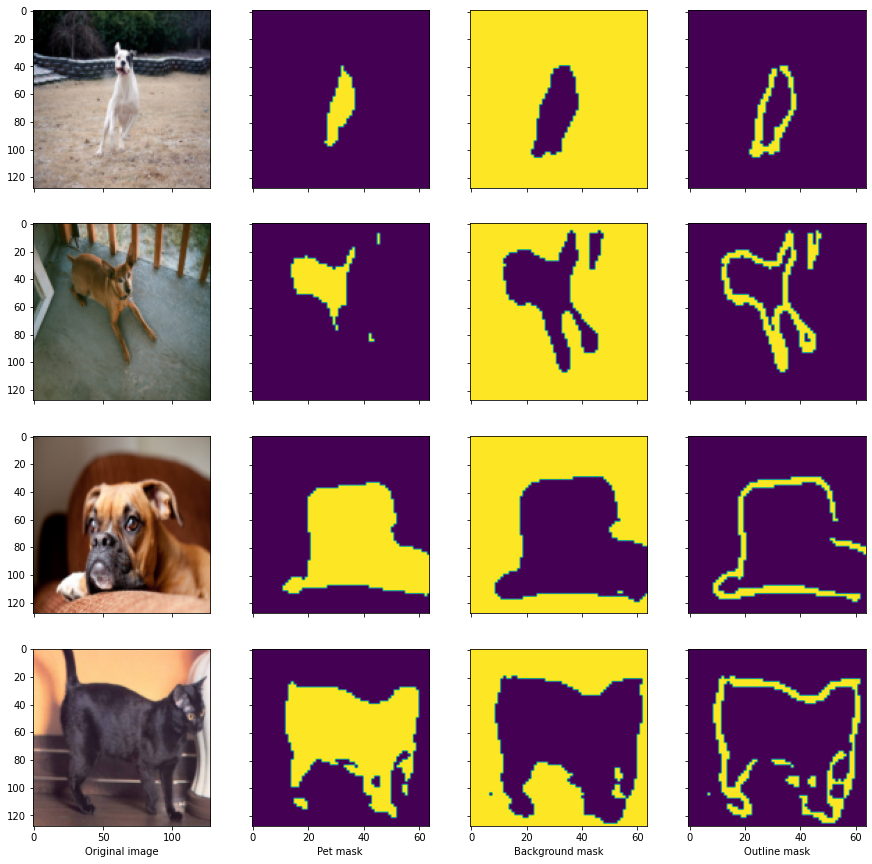

In [ ]:
samples = next(iter(TEST_LOADER))
images, _ = samples

images = images[:4]
logits = model(images.to(DEVICE))
prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)


visualize_data(images.cpu(), prediction.cpu())

# Experiments and ablations (2p)

## No BiFPN (1p)
Disable BiFPN and train the model. Compare the performance with the previous one. 
That is, make BiFPN an identity on features.   
Do it without redefining the class `Net`.

In [ ]:
## TODO {
model, optimizer = create_model_and_optimizer()

model.fpn = nn.Identity()  # disable BiFPN

# }

train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Epoch 0 finished
Train set performance:
IOU PET: 0.486160191501508
IOU BG: 0.6631868933053805
IOU OUT: 0.0995725920029831
ACC PET: 0.7498842322308085
ACC BG: 0.7829554682192595
ACC OUT: 0.8843216605808424

Test set performance:
IOU PET: 0.4898239092410132
IOU BG: 0.662689223418792
IOU OUT: 0.1036453076495864
ACC PET: 0.7542542618475743
ACC BG: 0.7863078830871831
ACC OUT: 0.8771058376558667


Epoch 1 finished
Train set performance:
IOU PET: 0.48870534253384207
IOU BG: 0.7020694807640054
IOU OUT: 0.16861668406285124
ACC PET: 0.8046943332837976
ACC BG: 0.7907994145932404
ACC OUT: 0.8844913648522419

Test set performance:
IOU PET: 0.4870558118530673
IOU BG: 0.6944625741699976
IOU OUT: 0.17039928862426065
ACC PET: 0.8069727334380962
ACC BG: 0.7878262927142955
ACC OUT: 0.8776706415874557


Epoch 2 finished
Train set performance:
IOU PET: 0.5398306255713848
IOU BG: 0.7030604168872969
IOU OUT: 0.1474337

## Train Set Augmentations (1p)

To quickly see how data augmentation can help in learning we will restrict ourselves to first 20 images of `TRAIN_DATASET`.

In [ ]:
images, masks = [], []
it = iter(TRAIN_DATASET)
for i in range(20):
    img, mask = next(it)
    images.append(img)
    masks.append(mask)

stacked_images = torch.stack(images).repeat((200, 1, 1, 1))
stacked_masks = torch.stack(masks).repeat((200, 1, 1))


SMALL_TRAIN_DATASET = torch.utils.data.TensorDataset(stacked_images, stacked_masks)

SMALL_TRAIN_LOADER = torch.utils.data.DataLoader(
    SMALL_TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Complete the implementation of the augmentation function and train the model from scratch on the augmented dataset (use the `SMALL_TRAIN_LOADER` presented above). Write a short summary of the results. Augmentations are up to you, but they should result in performance improvement.

In [ ]:
def augment_data(images, ground_truth):
    """
    Args:
        images of shape (B, 3, H, W)
        ground_truth of shape (B, H', W')
    Returns augmented images and ground_truth.
    Augmentation is random.
    """

    batch_size = images.shape[0]
    assert len(images.shape) == 4 # (B, 3, H, W)
    assert len(ground_truth.shape) == 3 # (B, H', W')

    assert ground_truth.shape[0] == batch_size

    ## TODO {
        
    aug_images = []
    aug_gt = []

    for i in range(batch_size):
        # Random horizontal and vertical flip
        image = images[i]
        gt = ground_truth[i]

        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            gt = TF.hflip(gt)

        # Random rotation
        angle = transforms.RandomRotation.get_params(degrees=(-20, 20))
        image = transforms.functional.rotate(image, angle)

        gt = transforms.functional.rotate(torch.unsqueeze(gt, 0), angle, fill=1)

        aug_images.append(image.unsqueeze(0))
        aug_gt.append(gt)

    aug_images = torch.cat(aug_images, dim=0)
    aug_gt = torch.cat(aug_gt, dim=0)

     ## }

    assert aug_images.shape == images.shape
    assert ground_truth.shape == aug_gt.shape
    assert torch.logical_or(aug_gt == 0, torch.logical_or(aug_gt == 1, aug_gt == 2)).all()


    return aug_images, aug_gt

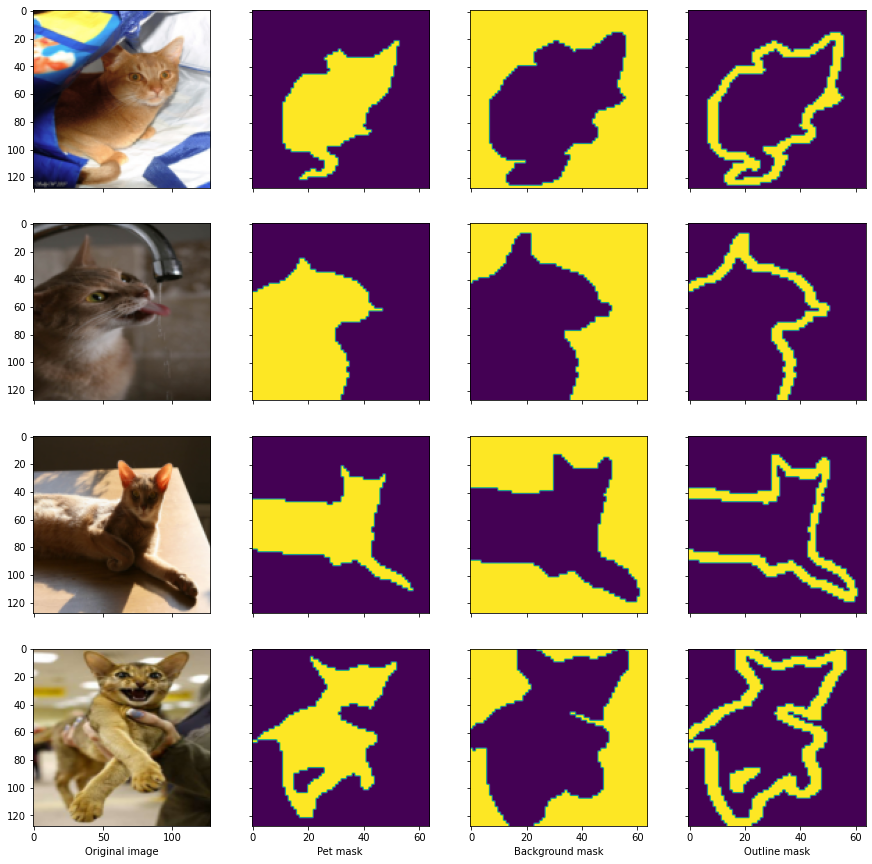

In [ ]:
samples = next(iter(SMALL_TRAIN_LOADER))
images, masks = samples

images = images[:4]
masks = masks[:4]


visualize_data(images, masks)

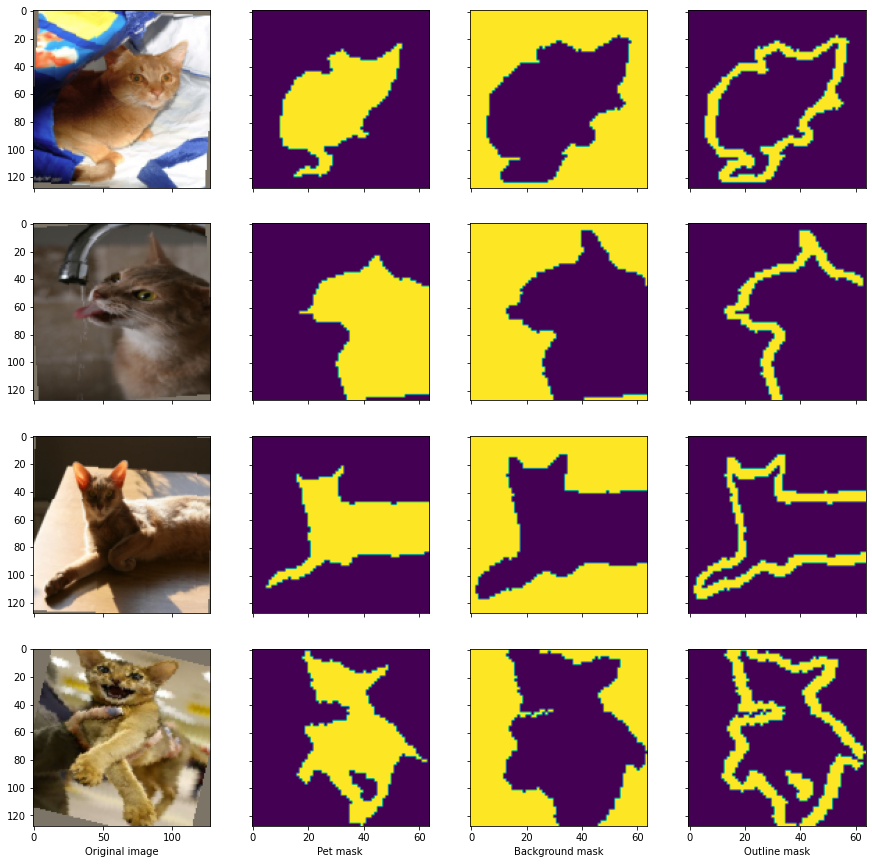

In [ ]:
aug_imgs, aug_masks = augment_data(images, masks)


visualize_data(aug_imgs, aug_masks)

In [ ]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 finished
Train set performance:
IOU PET: 0.9660107792032138
IOU BG: 0.9794288927383241
IOU OUT: 0.8683461437683708
ACC PET: 0.99222412109375
ACC BG: 0.98907470703125
ACC OUT: 0.981298828125

Test set performance:
IOU PET: 0.43654860021256914
IOU BG: 0.6914399283223929
IOU OUT: 0.30017481054001277
ACC PET: 0.7940362746788975
ACC BG: 0.7777972300652426
ACC OUT: 0.8656298974516217


Epoch 1 finished
Train set performance:
IOU PET: 0.9891278408131368
IOU BG: 0.9964640314125777
IOU OUT: 0.9695298620154048
ACC PET: 0.9976318359375
ACC BG: 0.99822998046875
ACC OUT: 0.99586181640625

Test set performance:
IOU PET: 0.4893692938287952
IOU BG: 0.6850663239099393
IOU OUT: 0.3085828553238531
ACC PET: 0.7949697848528209
ACC BG: 0.7878662841331084
ACC OUT: 0.8603576177730649


Epoch 2 finished
Train set performance:
IOU PET: 0.9783088062713564
IOU BG: 0.9947658113514607
IOU OUT: 0.945330978916573
ACC PET: 0.99503173828125
ACC BG: 0.99722900390625


In [ ]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn, augment_fn=augment_data)

Loaded pretrained weights for efficientnet-b0
Epoch 0 finished
Train set performance:
IOU PET: 0.9374629975419733
IOU BG: 0.97387364713832
IOU OUT: 0.8073469302722185
ACC PET: 0.9857177734375
ACC BG: 0.98583984375
ACC OUT: 0.9715576171875

Test set performance:
IOU PET: 0.5597267200065196
IOU BG: 0.7688117321437254
IOU OUT: 0.32476693196999734
ACC PET: 0.8537254967719405
ACC BG: 0.8486763971577747
ACC OUT: 0.8586538901735827


Epoch 1 finished
Train set performance:
IOU PET: 0.9643240322652232
IOU BG: 0.9841019541725086
IOU OUT: 0.8835567647513599
ACC PET: 0.99183349609375
ACC BG: 0.9916015625
ACC OUT: 0.98343505859375

Test set performance:
IOU PET: 0.5260736367682867
IOU BG: 0.7464494874539038
IOU OUT: 0.3331307242227463
ACC PET: 0.8358505968502998
ACC BG: 0.8274951185183292
ACC OUT: 0.8645306324952303


Epoch 2 finished
Train set performance:
IOU PET: 0.971982554604952
IOU BG: 0.9880657956924204
IOU OUT: 0.9133498050591207
ACC PET: 0.99381103515625
ACC BG: 0.99384765625
ACC OUT: 0.9

## Report

### Results for model with & without BiFPN:

| Metric on test | BiFPN: Yes | BiFPN: No |
|----------------|------------|-----------|
| IOU PET        | 0.822      | 0.540     |
| IOU BG         | 0.902      | 0.700     |
| IOU OUT        | 0.501      | 0.150     |
| ACC PET        | 0.948      | 0.799     |
| ACC BG         | 0.947      | 0.810     |
| ACC OUT        | 0.927      | 0.884     |

We can observe dramatic improvement of IOU and ACC when using BiFPN!

### Results for using  train set augmentation:
|          | Results without augmentation: | Results with augmentation: |
|----------|------------------------------|-----------------------------|
| IOU PET  | 0.487                       | 0.529                      |
| IOU BG   | 0.716                       | 0.749                      |
| IOU OUT  | 0.315                       | 0.336                      |
| ACC PET  | 0.813                       | 0.838                      |
| ACC BG   | 0.807                       | 0.830                      |
| ACC OUT  | 0.862                       | 0.868                      | 


We can see that augmentating the training data, even with basic transformations like horizontal flipping or rotation, can be really beneficial to the final model performance (especially when dealing with small data sets).

# Optional
Below you are provided with code for testing you model on images from the web. It may not work in colab!

In [ ]:
load_checkpoint(model, "pet_segmentator.model")

In [ ]:
import io
import requests
from PIL import Image


def download_image(url):
    req = requests.get(url, timeout=4.0)
    if req.status_code != requests.codes.ok:
        raise ConnectionError("Could not request image")

    return Image.open(io.BytesIO(req.content))


img_list = [
    download_image(
        "https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Young_tabby_cat_keeping_watch.jpg/1920px-Young_tabby_cat_keeping_watch.jpg?20190125193716"  #By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=76097663
    ),
    download_image( 
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Cat_blooper.jpg/1920px-Cat_blooper.jpg?20190116232839" # By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=75900016
    ),
]
img = []
for i in img_list:
    img.append(input_transforms(i))


img = torch.stack(img, dim=0)
logits = model(img.to(DEVICE))

prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)

masks = prediction.detach().cpu()



visualize_data(img, masks)